# Clasificador simple sobre datos estructurados

Nos basaremos el tutorial [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/), uno de los [ejemplos de Keras sobre datos estructurados](https://keras.io/examples/structured_data/), para utilizar Keras sobre datos de un dominio con el que estamos famirializados.

Utilizaremos el dataset [Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/) para demostrar cómo entrenar un clasificador simple en Keras sobre datos con clases desbalanceadas.


Realizaremos los siguientes pasos:

1. Carga del dataset
2. Preparación del conjunto de validación
4. Análisis del "desbalance" de clases
5. Estandarización (manual) de datos
6. Definición del modelo
7. Entrenamiento del modelo

## 1. Carga de datos

In [2]:
# import os

# # Crear el directorio ./data si no existe
# os.makedirs('./data', exist_ok=True)

# # Descargar el archivo con gdown
# !pip install gdown
# !gdown 1TldKEcayYQDOghWTop67-jOeu05YrRCs -O ./data/creditcard.csv.zip

# # Descomprimir el archivo
# import zipfile

# with zipfile.ZipFile('./data/creditcard.csv.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data/')


https://drive.google.com/file/d/11jIiAfoZNLA9pvGp6qEtaR2E6EuxYJip/view?usp=sharing

In [3]:
import os

# Crear el directorio ./data si no existe
os.makedirs('./data', exist_ok=True)

# Descargar el archivo con gdown
!pip install gdown
!gdown 11jIiAfoZNLA9pvGp6qEtaR2E6EuxYJip -O ./data/SAheart.csv

# # Descomprimir el archivo
# import zipfile

# with zipfile.ZipFile('./data/creditcard.csv.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data/')

Downloading...
From: https://drive.google.com/uc?id=11jIiAfoZNLA9pvGp6qEtaR2E6EuxYJip
To: /content/data/SAheart.csv
100% 22.2k/22.2k [00:00<00:00, 43.1MB/s]


In [4]:
from pathlib import Path

import numpy as np
import pandas as pd


np.random.seed(0)

PATH = Path("data", "SAheart.csv")
df = pd.read_csv(PATH)

df["famhist"] = df["famhist"].replace({"Absent":0, "Present":1})
df["chd"] = df["chd"].replace({"No":0, "Si":1})

df.head()

features = np.array(df.iloc[:, :-1], dtype="float32")
targets = np.array(df.iloc[:, [-1]], dtype="uint8")

del df

print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

features.shape: (462, 9)
targets.shape: (462, 1)


## 2. Preparación de conjunto de validación

In [5]:
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

Number of training samples: 370
Number of validation samples: 92


## 3. Análisis del "desbalance" de clases

In [6]:
counts = pd.Series(train_targets.flatten()).value_counts()
print(counts)

0    238
1    132
Name: count, dtype: int64


In [7]:
print(
    f"Number of positive samples in training data: {counts.loc[1]} "
    f"({100 * float(counts.loc[1]) / len(train_targets):.2f}% of total)"
)

Number of positive samples in training data: 132 (35.68% of total)


In [8]:
weight_for_0 = 1.0 / counts.loc[0]
print(f"Weight for label 0: {weight_for_0}")
weight_for_1 = 1.0 / counts.loc[1]
print(f"Weight for label 1: {weight_for_1}")

Weight for label 0: 0.004201680672268907
Weight for label 1: 0.007575757575757576


## 4. Estandarización (manual) de datos

In [9]:
mean = np.mean(train_features, axis=0)
std = np.std(train_features, axis=0)

train_features = (train_features - mean) / std
val_features = (val_features - mean) / std

## 5. Definición de un modelo de clasificación binaria

In [10]:
train_features.shape[1:]

(9,)

In [11]:
import keras

keras.utils.set_random_seed(0)


# Equivalente en scikit: MLPClassifier(hidden_layer_sizes=(256,))
model = keras.Sequential(
    [
        keras.Input(shape=train_features.shape[1:]),  # 30
        keras.layers.Dense(256, activation="relu"),  # [X, 16, 64, 256]
        # keras.layers.Dense(256, activation="relu"),
        # keras.layers.Dropout(0.3),
        # keras.layers.Dense(256, activation="relu"),
        # keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),  # 1
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560      
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


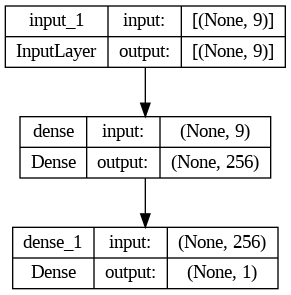

In [12]:
keras.utils.plot_model(model, show_shapes=True)

## 6. Entrenando el modelo con el argumento `class_weight`

In [13]:
# https://keras.io/api/metrics/
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics)

callbacks = [keras.callbacks.ModelCheckpoint("checkpoints/fraud_model_at_epoch_{epoch}.keras")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,  # TODO: Comparar modelo sin esta opción
)

Epoch 1/30
1/1 - 2s - loss: 0.0038 - fn: 104.0000 - fp: 27.0000 - tn: 211.0000 - tp: 28.0000 - precision: 0.5091 - recall: 0.2121 - val_loss: 0.5942 - val_fn: 8.0000 - val_fp: 23.0000 - val_tn: 41.0000 - val_tp: 20.0000 - val_precision: 0.4651 - val_recall: 0.7143 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 0.0033 - fn: 43.0000 - fp: 81.0000 - tn: 157.0000 - tp: 89.0000 - precision: 0.5235 - recall: 0.6742 - val_loss: 0.6051 - val_fn: 6.0000 - val_fp: 26.0000 - val_tn: 38.0000 - val_tp: 22.0000 - val_precision: 0.4583 - val_recall: 0.7857 - 114ms/epoch - 114ms/step
Epoch 3/30
1/1 - 0s - loss: 0.0031 - fn: 26.0000 - fp: 94.0000 - tn: 144.0000 - tp: 106.0000 - precision: 0.5300 - recall: 0.8030 - val_loss: 0.6186 - val_fn: 4.0000 - val_fp: 27.0000 - val_tn: 37.0000 - val_tp: 24.0000 - val_precision: 0.4706 - val_recall: 0.8571 - 105ms/epoch - 105ms/step
Epoch 4/30
1/1 - 0s - loss: 0.0031 - fn: 24.0000 - fp: 95.0000 - tn: 143.0000 - tp: 108.0000 - precision: 0.5320 - recall: 0.8182 -

In [14]:
val_results = model.evaluate(val_features, val_targets)
# Métricas resultantes
val_results

3/3 [==============================] - 0s 49ms/step - loss: 0.6081 - fn: 9.0000 - fp: 20.0000 - tn: 44.0000 - tp: 19.0000 - precision: 0.4872 - recall: 0.6786


[0.6081216931343079,
 9.0,
 20.0,
 44.0,
 19.0,
 0.4871794879436493,
 0.6785714030265808]

In [15]:
# Formato ordenado
pd.DataFrame([val_results], columns=model.metrics_names)

,loss,fn,fp,tn,tp,precision,recall
0,0.608122,9.0,20.0,44.0,19.0,0.487179,0.678571


En este punto, de las 56.961 transacciones utilizadas en el conjunto de validación, hemos:

* Identificado correctamente a 64 de ellas como fraudulentas
* Fallado en identificar 11 transacciones fraudulentas
* Al costo de marcar incorrectamente 155 transacciones legítimas

En el mundo real, probablamente se le daría más peso a la clase 1, para reflejar que los falsos negativos son más costosos que los falsos positivos.

> Si nuestra tarjeta de crédito es rechazada en una compra online, esta es la razón.

## 7. Serializar y deserializar un modelo en Keras

In [16]:
OUTPUT_PATH = "model.keras"
model.save(OUTPUT_PATH)

In [17]:
model_loaded = keras.models.load_model(OUTPUT_PATH)

In [18]:
# Formato ordenado
pd.DataFrame([model_loaded.evaluate(val_features, val_targets)], columns=model_loaded.metrics_names)

3/3 [==============================] - 2s 24ms/step - loss: 0.6081 - fn: 9.0000 - fp: 20.0000 - tn: 44.0000 - tp: 19.0000 - precision: 0.4872 - recall: 0.6786


,loss,fn,fp,tn,tp,precision,recall
0,0.608122,9.0,20.0,44.0,19.0,0.487179,0.678571


Estas métricas fueron el resultado del modelo que entrenamos (antes de serializar). Notar que son exactamente iguales a las obtenidas por el modelo que acabamos de deserializar, pues son exactamente el mismo modelo (mismos pesos):

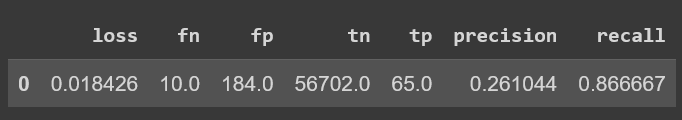

In [19]:
import pandas as pd
import tensorflow.keras as keras

# Definir los datos de ejemplo
data = {
    'sbp': [102],
    'tobacco': [0],
    'ldl': [0.98],
    'adiposity': [6.74],
    'famhist': [0],  # Cambiado 'Absent' a 0
    'typea': [13],
    'obesity': [14.7],
    'alcohol': [117.22],
    'age': [15],
}


# Crear un DataFrame con los datos
df = pd.DataFrame(data)

# # Definir la función para convertir 'chd' a 0 o 1
# def convert_chd(value):
#     return 1 if value == 'Si' else 0

# # Aplicar la conversión a la columna 'chd'
# df['chd'] = df['chd'].apply(convert_chd)

# Cargar el modelo Keras entrenado (sustituye 'modelo.keras' con el nombre real de tu archivo)
model = keras.models.load_model('model.keras')

# Realizar la predicción
predictions = model.predict(df)

# Convertir las predicciones a valores binarios (0 o 1)
threshold = 0.5  # Umbral para decidir si es 0 o 1
predictions_binary = [1 if pred > threshold else 0 for pred in predictions]

# Mostrar las predicciones
print("Predicciones:")
for pred in predictions_binary:
    print(f"CHD: {'Si' if pred == 1 else 'No'}")


1/1 [==============================] - 0s 490ms/step
Predicciones:
CHD: No


In [20]:
model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,  # TODO: Comparar modelo sin esta opción
)




Epoch 1/30
1/1 - 5s - loss: 0.0024 - fn: 24.0000 - fp: 55.0000 - tn: 183.0000 - tp: 108.0000 - precision: 0.6626 - recall: 0.8182 - val_loss: 0.6115 - val_fn: 9.0000 - val_fp: 21.0000 - val_tn: 43.0000 - val_tp: 19.0000 - val_precision: 0.4750 - val_recall: 0.6786 - 5s/epoch - 5s/step
Epoch 2/30
1/1 - 0s - loss: 0.0024 - fn: 24.0000 - fp: 55.0000 - tn: 183.0000 - tp: 108.0000 - precision: 0.6626 - recall: 0.8182 - val_loss: 0.6144 - val_fn: 9.0000 - val_fp: 21.0000 - val_tn: 43.0000 - val_tp: 19.0000 - val_precision: 0.4750 - val_recall: 0.6786 - 284ms/epoch - 284ms/step
Epoch 3/30
1/1 - 0s - loss: 0.0024 - fn: 24.0000 - fp: 57.0000 - tn: 181.0000 - tp: 108.0000 - precision: 0.6545 - recall: 0.8182 - val_loss: 0.6173 - val_fn: 9.0000 - val_fp: 21.0000 - val_tn: 43.0000 - val_tp: 19.0000 - val_precision: 0.4750 - val_recall: 0.6786 - 249ms/epoch - 249ms/step
Epoch 4/30
1/1 - 0s - loss: 0.0024 - fn: 25.0000 - fp: 56.0000 - tn: 182.0000 - tp: 107.0000 - precision: 0.6564 - recall: 0.8106 

In [21]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]


metrics

In [22]:
tn=203.0000
fp=35.0000
fn=16.0000
tp=116.0000
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(accuracy)


0.8621621621621621


In [23]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

# Crear el directorio ./data si no existe
os.makedirs('./data', exist_ok=True)

# Descargar el archivo con gdown
!pip install gdown
!gdown https://drive.google.com/uc?id=11jIiAfoZNLA9pvGp6qEtaR2E6EuxYJip -O ./data/SAheart.csv

# Cargar el dataset SAheart
PATH = Path("data", "SAheart.csv")
df = pd.read_csv(PATH)

# Reemplazar valores categóricos con numéricos
df["famhist"] = df["famhist"].replace({"Absent": 0, "Present": 1})
df["chd"] = df["chd"].replace({"No": 0, "Yes": 1})

# Separar features y targets
features = df.drop(columns=["chd"]).values.astype(np.float32)
targets = df["chd"].values.astype(np.uint8)

# Dividir en conjunto de entrenamiento y validación
train_features, val_features, train_targets, val_targets = train_test_split(
    features, targets, test_size=0.2, random_state=42, stratify=targets
)

# Estandarización de datos
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

# Análisis del desbalance de clases
class_counts = np.bincount(train_targets)
total_count = len(train_targets)
weight_for_0 = (1 / class_counts[0]) * (total_count / 2.0)
weight_for_1 = (1 / class_counts[1]) * (total_count / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

# Definición del modelo en Keras
model = keras.Sequential([
    keras.layers.Input(shape=train_features.shape[1]),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

# Compilación del modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(name='auc')
    ]
)

# Entrenamiento del modelo
history = model.fit(
    train_features, train_targets,
    epochs=30,
    batch_size=2048,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
    verbose=2
)

# Evaluación del modelo en el conjunto de validación
val_results = model.evaluate(val_features, val_targets)
print("Validation results:")
for name, value in zip(model.metrics_names, val_results):
    print(f"{name}: {value}")

# Guardar el modelo entrenado
model.save("saheart_model.h5")


Downloading...
From: https://drive.google.com/uc?id=11jIiAfoZNLA9pvGp6qEtaR2E6EuxYJip
To: /content/data/SAheart.csv
100% 22.2k/22.2k [00:00<00:00, 28.1MB/s]


ValueError: invalid literal for int() with base 10: 'Si'